In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Cityscapes
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
label_map = {
    0 : ['unlabeled', 255, 'void'], 
    1 : ['ego vehicle', 255, 'void'],
    2 : ['rectification border', 255, 'void'],
    3 : ['out of roi', 255, 'void'],
    4 : ['static', 255, 'void'],
    5 : ['dynamic', 255, 'void'],
    6 : ['ground', 255, 'void'],
    7 : ['road', 0, 'flat'],
    8 : ['sidewalk', 1, 'flat'],
    9 : ['parking', 255, 'flat'],
    10 : ['rail track', 255, 'flat'],
    11 : ['building', 2, 'construction'],
    12 : ['wall', 3, 'construction'],
    13 : ['fence', 4, 'construction'],
    14 : ['guard rail', 255, 'construction'],
    15 : ['bridge', 255, 'construction'],
    16 : ['tunnel', 255, 'construction'],
    17 : ['pole', 5, 'object'],
    18 : ['polegroup', 255, 'object'],
    19 : ['traffic light', 6, 'object'],
    20 : ['traffic sign', 7, 'object'],
    21 : ['vegetation', 8, 'nature'],
    22 : ['terrain', 9, 'nature'],
    23 : ['sky', 10, 'sky'],
    24 : ['person', 11, 'human'],
    25 : ['rider', 12, 'human'],
    26 : ['car', 13, 'vehicle'],
    27 : ['truck', 14, 'vehicle'],
    28 : ['bus', 15, 'vehicle'],
    29 : ['caravan', 255, 'vehicle'],
    30 : ['trailer', 255, 'vehicle'],
    31 : ['train', 16, 'vehicle'],
    32 : ['motorcycle', 17, 'vehicle'],
    33 : ['bicycle', 18, 'vehicle'],
    34 : ['license plate', -1, 'vehicle']
}

In [3]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in label_map:
            encx[x == label] = label_map[label][1] if label_map[label][1] != 255 else 19
        return F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "train", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

valid_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "val", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform    
)

test_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "test", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=16)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=16)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=16)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 2975
#Validation Samples: 500
#Testing Samples: 1525
#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


Total #Classes: 20
data shape: torch.Size([3, 256, 512])
mask shape: torch.Size([20, 256, 512])
Number classes: 20
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 19])


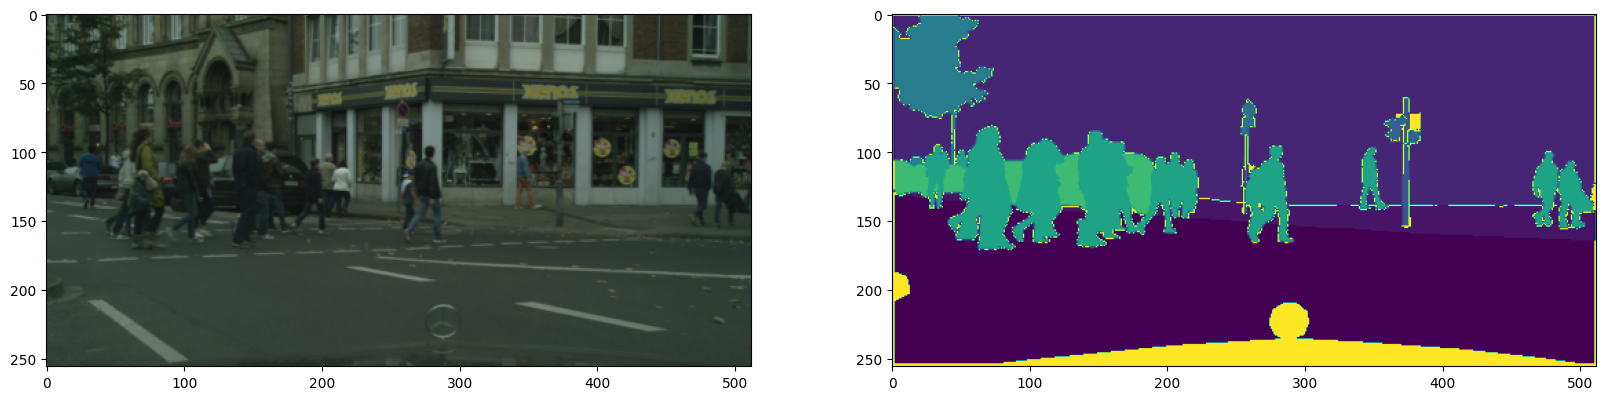

In [5]:
sample_data, sample_mask = train_ds[19]
total_num_class = 20

print(f"Total #Classes: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, total_num_class, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        
        weight = train_mask.sum() / (train_mask.sum((0, 2, 3)) * total_num_class)
        weight[torch.mul(weight > 0, weight < 1)] = 1
        loss_fn = nn.CrossEntropyLoss(weight = weight)
        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            loss_fn = nn.CrossEntropyLoss()
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 0 - TrainLoss: 2.9650901081741496 - ValidLoss: 0.7947768370310465


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Epoch: 1 - TrainLoss: 1.9121133922248759 - ValidLoss: 0.5149628321329752


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 2 - TrainLoss: 1.4938010067068122 - ValidLoss: 0.4507729212443034


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


Epoch: 3 - TrainLoss: 1.3026581425820627 - ValidLoss: 0.40991854667663574


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Epoch: 4 - TrainLoss: 1.1969100730393523 - ValidLoss: 0.37441356976826984


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Epoch: 5 - TrainLoss: 1.133206448888266 - ValidLoss: 0.3745794693628947


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


Epoch: 6 - TrainLoss: 1.0905475321636404 - ValidLoss: 0.37957318623860675


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Epoch: 7 - TrainLoss: 1.05151500240449 - ValidLoss: 0.3531918525695801


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.36s/it]


Epoch: 8 - TrainLoss: 1.01300351401811 - ValidLoss: 0.30790507793426514


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Epoch: 9 - TrainLoss: 0.9854596552028451 - ValidLoss: 0.367007573445638


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 10 - TrainLoss: 0.9556713815658323 - ValidLoss: 0.3194909493128459


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Epoch: 11 - TrainLoss: 0.9304525595839306 - ValidLoss: 0.27313554286956787


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 12 - TrainLoss: 0.9065608805225741 - ValidLoss: 0.3060286243756612


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


Epoch: 13 - TrainLoss: 0.8881218760244308 - ValidLoss: 0.2980238397916158


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Epoch: 14 - TrainLoss: 0.8613792587352055 - ValidLoss: 0.28317878643671673


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 15 - TrainLoss: 0.8405084834303908 - ValidLoss: 0.2893881599108378


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 16 - TrainLoss: 0.8217031276354225 - ValidLoss: 0.2991040547688802


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.60it/s]


Epoch: 17 - TrainLoss: 0.8082872116437523 - ValidLoss: 0.3448624610900879


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.42s/it]


Epoch: 18 - TrainLoss: 0.7831693266027717 - ValidLoss: 0.2505134145418803


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


Epoch: 19 - TrainLoss: 0.7620564032626408 - ValidLoss: 0.2702837785085042


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.10s/it]


Epoch: 20 - TrainLoss: 0.7565159387485956 - ValidLoss: 0.26027170817057294


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:35<00:00,  2.23s/it]


Epoch: 21 - TrainLoss: 0.7319686015446981 - ValidLoss: 0.2530201276143392


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Epoch: 22 - TrainLoss: 0.7110992195785687 - ValidLoss: 0.22814961274464926


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Epoch: 23 - TrainLoss: 0.717006794867977 - ValidLoss: 0.2335077921549479


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Epoch: 24 - TrainLoss: 0.6923723233643398 - ValidLoss: 0.24040440718332926


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch: 25 - TrainLoss: 0.6743019069394758 - ValidLoss: 0.22012251615524292


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


Epoch: 26 - TrainLoss: 0.6690935133605875 - ValidLoss: 0.2313652237256368


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch: 27 - TrainLoss: 0.6489831939820321 - ValidLoss: 0.21032923460006714


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch: 28 - TrainLoss: 0.637855475948703 - ValidLoss: 0.20490650335947672


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Epoch: 29 - TrainLoss: 0.6311188442732698 - ValidLoss: 0.20311435063680014


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 30 - TrainLoss: 0.6101760069529215 - ValidLoss: 0.21584341923395792


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


Epoch: 31 - TrainLoss: 0.602239163332088 - ValidLoss: 0.1740581194559733


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Epoch: 32 - TrainLoss: 0.5894910186849615 - ValidLoss: 0.19313079118728638


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


Epoch: 33 - TrainLoss: 0.5825863054362677 - ValidLoss: 0.19116326173146567


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 34 - TrainLoss: 0.5744806560136939 - ValidLoss: 0.17605926593144736


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.60it/s]


Epoch: 35 - TrainLoss: 0.5570048221977808 - ValidLoss: 0.18135923147201538


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


Epoch: 36 - TrainLoss: 0.5498485235116815 - ValidLoss: 0.1712143818537394


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 37 - TrainLoss: 0.5365511922426122 - ValidLoss: 0.1800518035888672


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


Epoch: 38 - TrainLoss: 0.5257113252275734 - ValidLoss: 0.18008343378702799


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


Epoch: 39 - TrainLoss: 0.5308286935411474 - ValidLoss: 0.15825792153676352


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


Epoch: 40 - TrainLoss: 0.5187716868615919 - ValidLoss: 0.17083430290222168


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 41 - TrainLoss: 0.5081856084126298 - ValidLoss: 0.18426978588104248


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


Epoch: 42 - TrainLoss: 0.5053001321772094 - ValidLoss: 0.1746119260787964


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 43 - TrainLoss: 0.49365905055435755 - ValidLoss: 0.16502677400906882


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Epoch: 44 - TrainLoss: 0.487207712986136 - ValidLoss: 0.1709812879562378


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.13it/s]


Epoch: 45 - TrainLoss: 0.4801259979765902 - ValidLoss: 0.17740829785664877


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Epoch: 46 - TrainLoss: 0.4821761365859739 - ValidLoss: 0.16056211789449057


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch: 47 - TrainLoss: 0.47456786036491394 - ValidLoss: 0.1506722370783488


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


Epoch: 48 - TrainLoss: 0.48553528292204745 - ValidLoss: 0.16190938154856363


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


Epoch: 49 - TrainLoss: 0.4734672102876889 - ValidLoss: 0.16761229435602823


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


Epoch: 50 - TrainLoss: 0.45474526189988657 - ValidLoss: 0.14249146978060404


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


Epoch: 51 - TrainLoss: 0.4477091691186351 - ValidLoss: 0.14809969067573547


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


Epoch: 52 - TrainLoss: 0.4436187071184958 - ValidLoss: 0.1429697871208191


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.73it/s]


Epoch: 53 - TrainLoss: 0.439111533985343 - ValidLoss: 0.15859611829121908


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 54 - TrainLoss: 0.4357509510491484 - ValidLoss: 0.1502014398574829


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 55 - TrainLoss: 0.4359344010071088 - ValidLoss: 0.14067761103312174


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


Epoch: 56 - TrainLoss: 0.4343223305799628 - ValidLoss: 0.14021900296211243


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


Epoch: 57 - TrainLoss: 0.42609890750659407 - ValidLoss: 0.14071803291638693


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


Epoch: 58 - TrainLoss: 0.42417673718544746 - ValidLoss: 0.1328509251276652


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Epoch: 59 - TrainLoss: 0.42052860093373123 - ValidLoss: 0.14669150114059448


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


Epoch: 60 - TrainLoss: 0.41646176320250317 - ValidLoss: 0.14472201466560364


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 61 - TrainLoss: 0.41094189241368284 - ValidLoss: 0.14140607913335165


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Epoch: 62 - TrainLoss: 0.4121847639801682 - ValidLoss: 0.13769265015920004


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


Epoch: 63 - TrainLoss: 0.4078432382434927 - ValidLoss: 0.1397061546643575


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Epoch: 64 - TrainLoss: 0.4040359563084059 - ValidLoss: 0.13908923665682474


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Epoch: 65 - TrainLoss: 0.402617694229208 - ValidLoss: 0.13798896471659342


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 66 - TrainLoss: 0.4009809452359394 - ValidLoss: 0.13695130745569864


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.71it/s]


Epoch: 67 - TrainLoss: 0.3976912876611115 - ValidLoss: 0.12012035648028056


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 68 - TrainLoss: 0.3941777454268548 - ValidLoss: 0.13585318128267923


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


Epoch: 69 - TrainLoss: 0.39224099375868354 - ValidLoss: 0.12705770134925842


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Epoch: 70 - TrainLoss: 0.3897081209767249 - ValidLoss: 0.12928277254104614


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.70it/s]


Epoch: 71 - TrainLoss: 0.3883465188805775 - ValidLoss: 0.13269296288490295


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


Epoch: 72 - TrainLoss: 0.3868099537587935 - ValidLoss: 0.1257974406083425


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 73 - TrainLoss: 0.384256879168172 - ValidLoss: 0.12613588571548462


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Epoch: 74 - TrainLoss: 0.3847988350417024 - ValidLoss: 0.12450773517290752


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


Epoch: 75 - TrainLoss: 0.3820634500313831 - ValidLoss: 0.11058883865674336


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.42it/s]


Epoch: 76 - TrainLoss: 0.38046762315175864 - ValidLoss: 0.1272201935450236


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 77 - TrainLoss: 0.37786121618363167 - ValidLoss: 0.13066095113754272


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch: 78 - TrainLoss: 0.3763244440478663 - ValidLoss: 0.11676519115765889


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 79 - TrainLoss: 0.3772269134880394 - ValidLoss: 0.13195117314656576


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


Epoch: 80 - TrainLoss: 0.3765815906627204 - ValidLoss: 0.12486175696055095


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


Epoch: 81 - TrainLoss: 0.37446872938063835 - ValidLoss: 0.1219716767470042


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Epoch: 82 - TrainLoss: 0.37192991247741125 - ValidLoss: 0.1378845771153768


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


Epoch: 83 - TrainLoss: 0.37140208578878836 - ValidLoss: 0.12508911887804666


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Epoch: 84 - TrainLoss: 0.3713905596604911 - ValidLoss: 0.12053895990053813


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch: 85 - TrainLoss: 0.37097514444781887 - ValidLoss: 0.1285033921400706


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


Epoch: 86 - TrainLoss: 0.36952527652504624 - ValidLoss: 0.12121615807215373


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


Epoch: 87 - TrainLoss: 0.3688900871302492 - ValidLoss: 0.11410277088483174


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


Epoch: 88 - TrainLoss: 0.368421329926419 - ValidLoss: 0.12650907039642334


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


Epoch: 89 - TrainLoss: 0.36775476926116535 - ValidLoss: 0.12666056553522745


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Epoch: 90 - TrainLoss: 0.36727992629492157 - ValidLoss: 0.1150093674659729


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


Epoch: 91 - TrainLoss: 0.36635695285694575 - ValidLoss: 0.13359556595484415


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Epoch: 92 - TrainLoss: 0.36696731082854733 - ValidLoss: 0.12148761749267578


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


Epoch: 93 - TrainLoss: 0.3662703674967571 - ValidLoss: 0.11702837546666463


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


Epoch: 94 - TrainLoss: 0.3662669617001728 - ValidLoss: 0.1278182566165924


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 95 - TrainLoss: 0.36564585149929085 - ValidLoss: 0.1179432471593221


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch: 96 - TrainLoss: 0.36595627985974793 - ValidLoss: 0.12065901358922322


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Epoch: 97 - TrainLoss: 0.36561806515980794 - ValidLoss: 0.12765591343243918


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Epoch: 98 - TrainLoss: 0.3659999114210888 - ValidLoss: 0.11822790900866191


100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]

Epoch: 99 - TrainLoss: 0.36537338649072953 - ValidLoss: 0.1284825603167216


<All keys matched successfully>

In [ ]:
loss_fn = nn.CrossEntropyLoss()
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

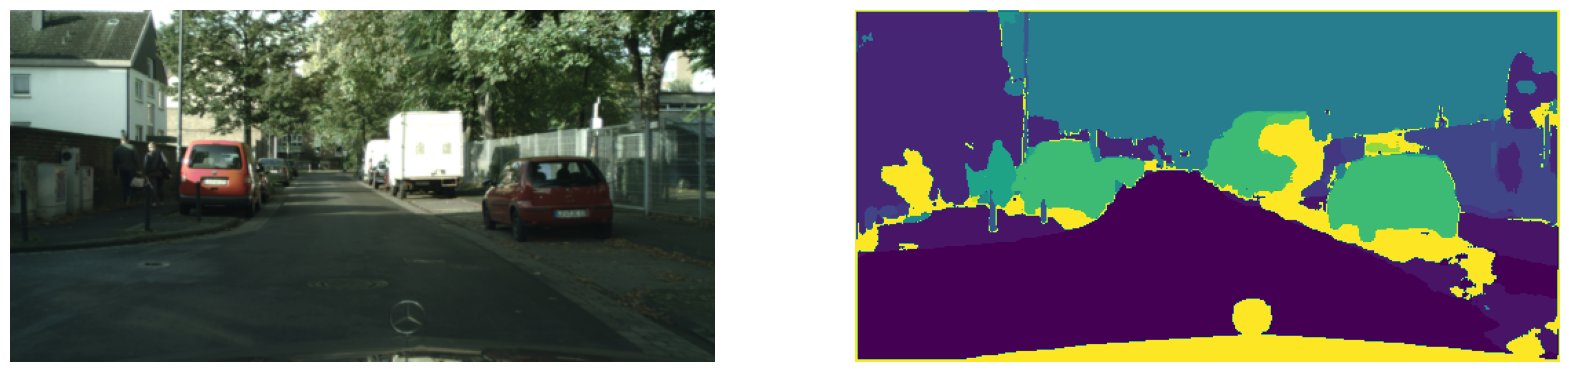

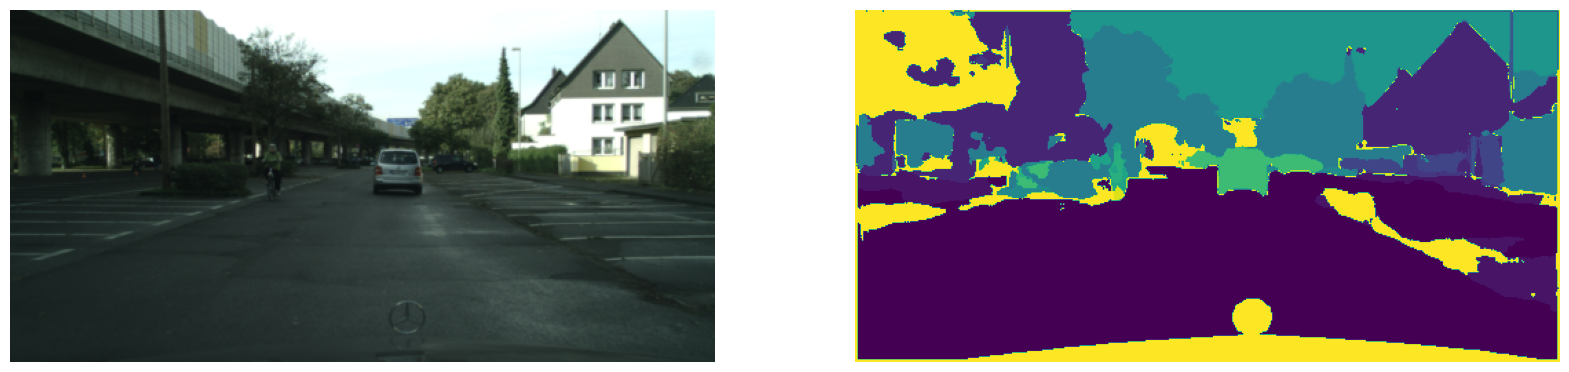

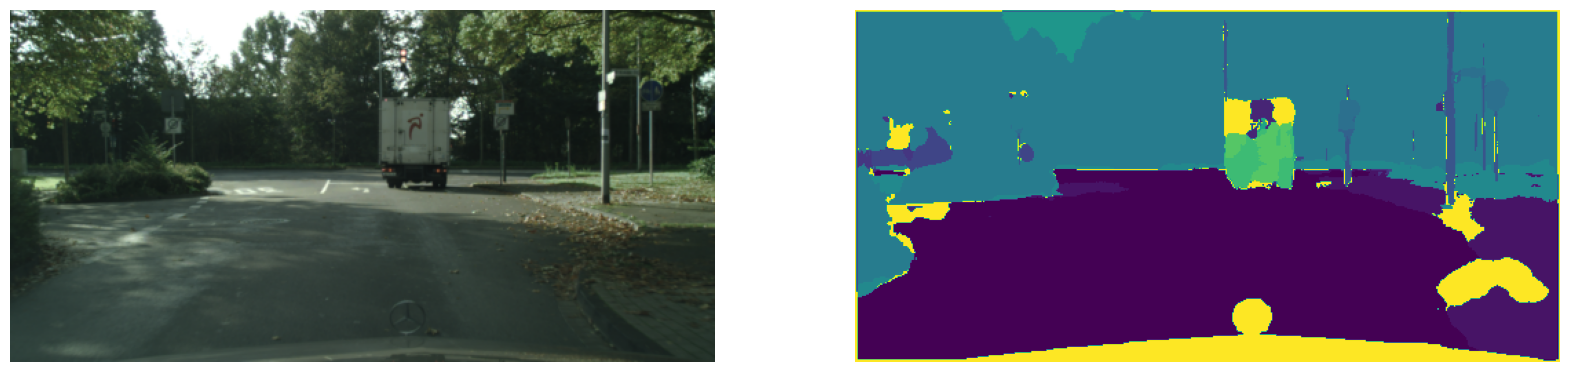

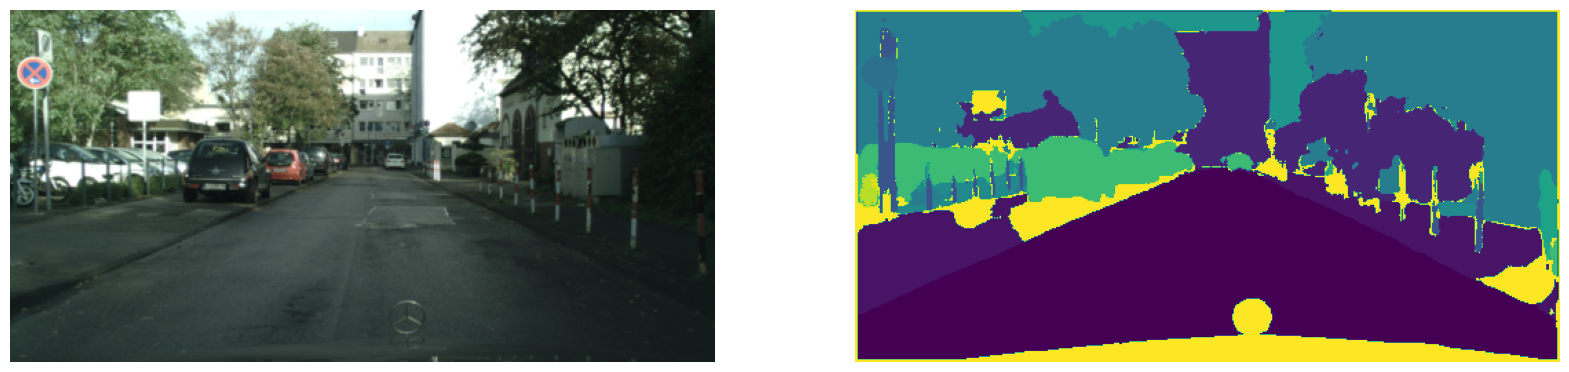

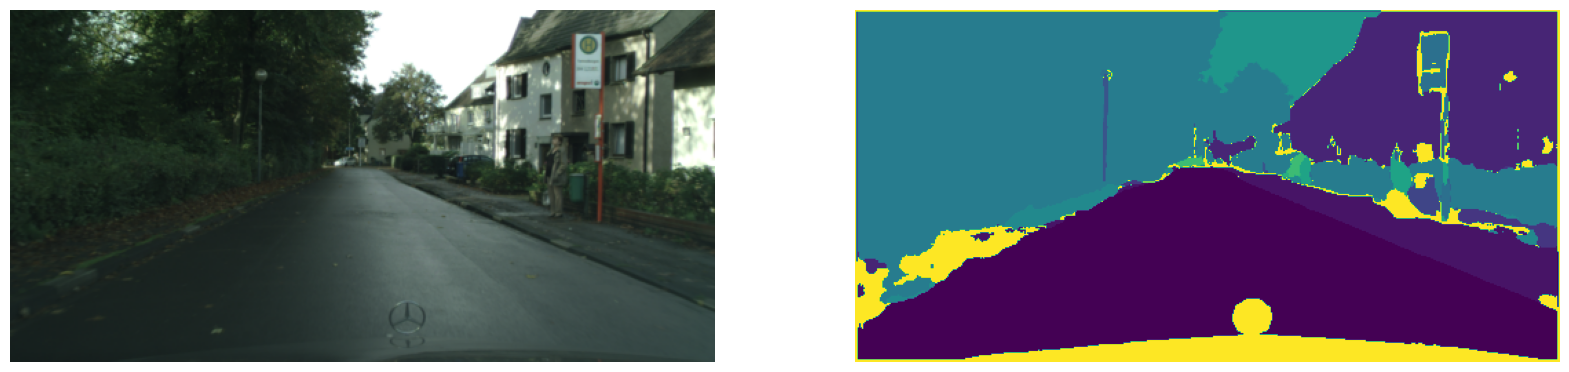

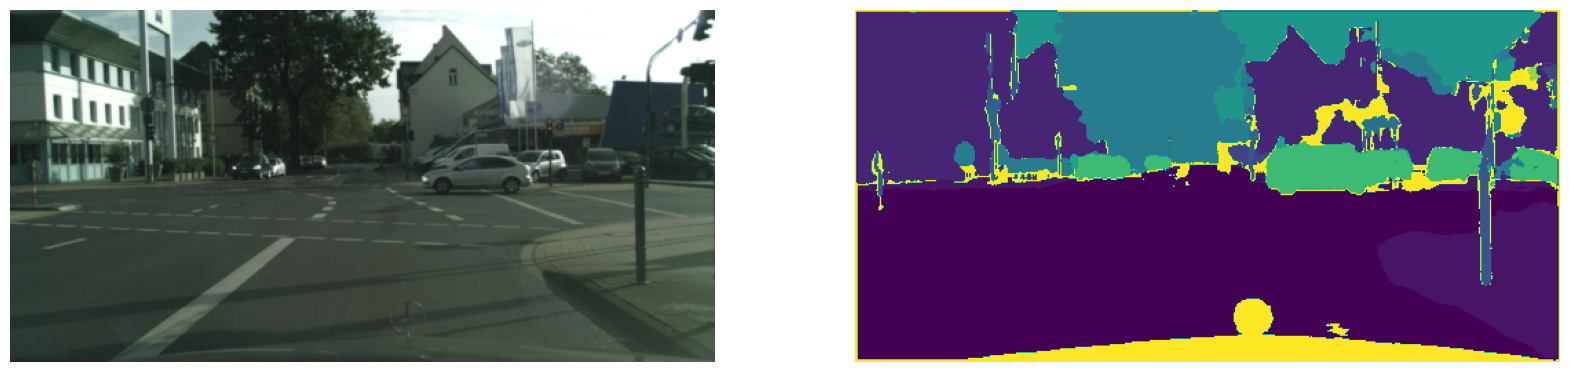

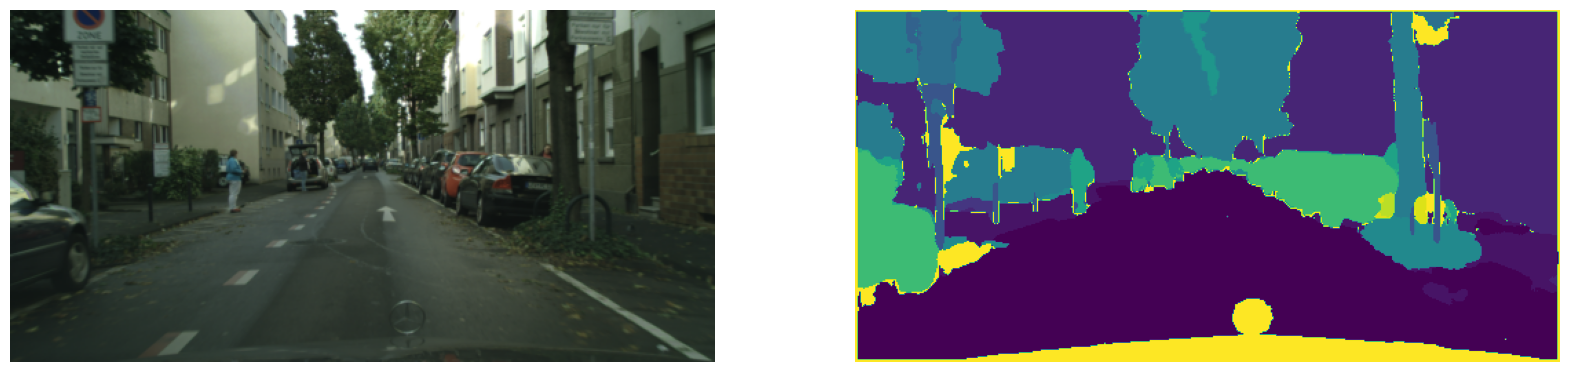

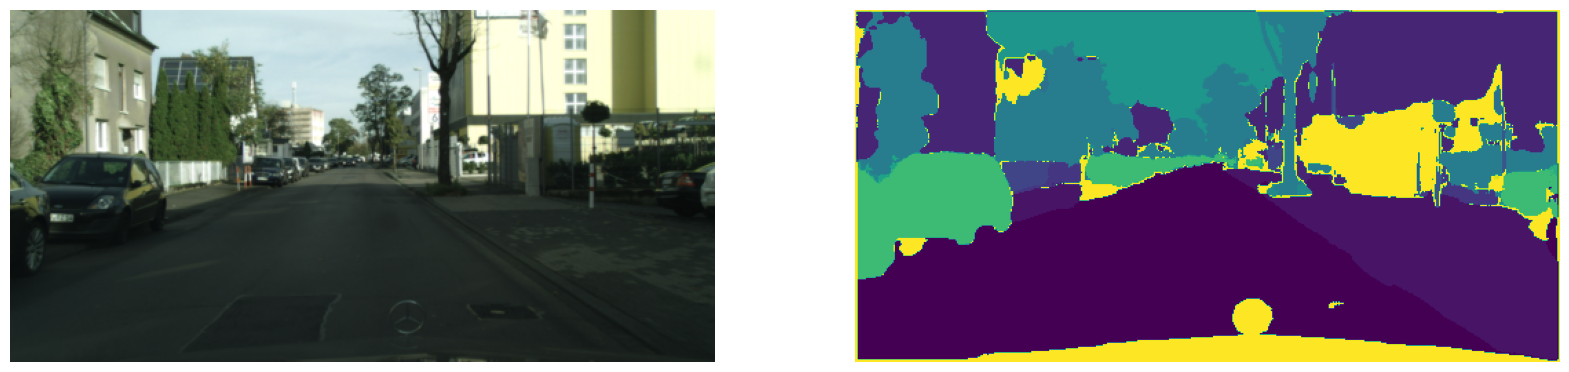

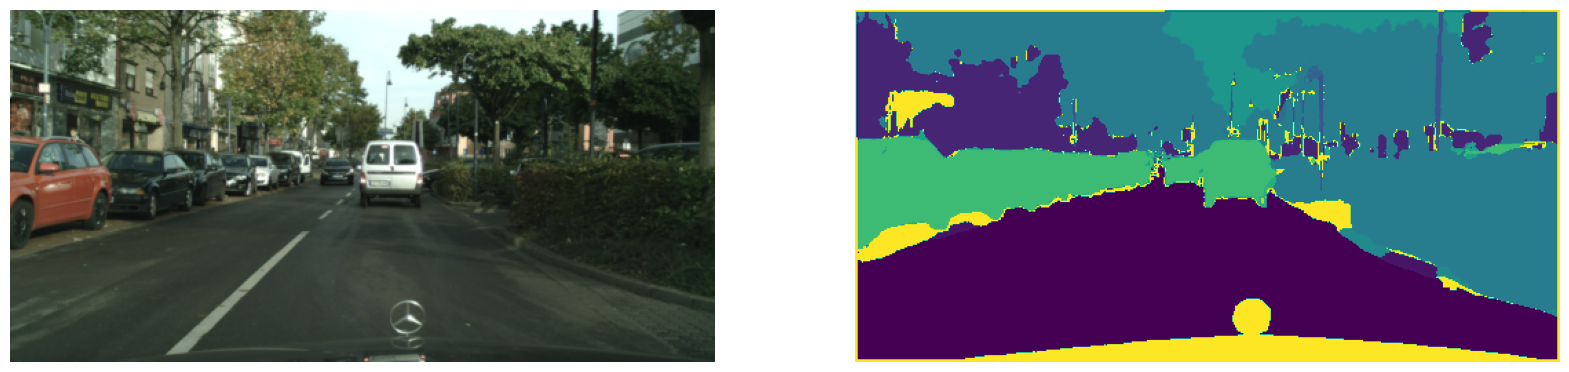

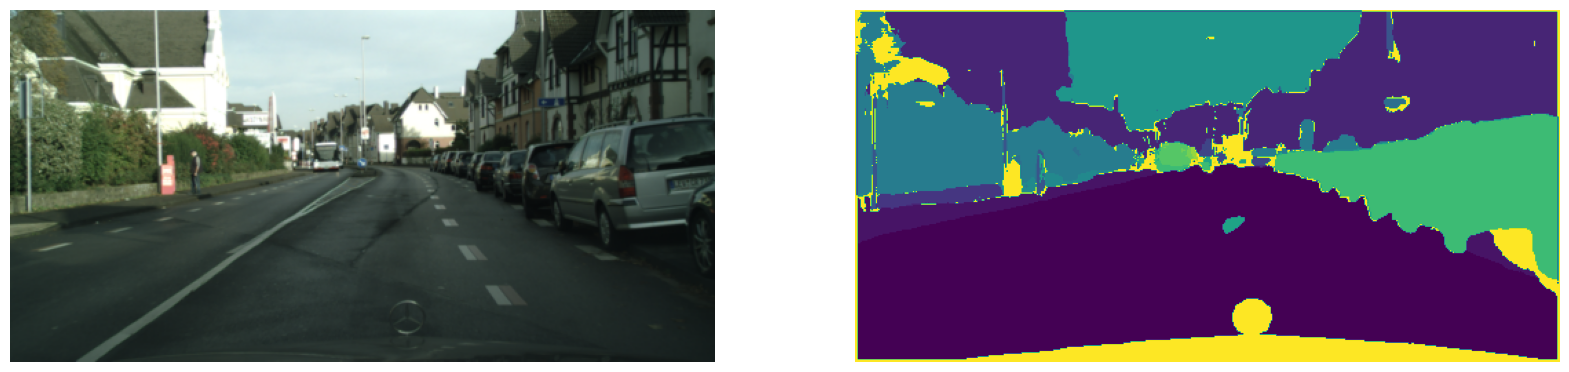

In [14]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')